<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-a00351269/blob/Regresiones_KMEANS/Actividad_Semana--7_KMEANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Actividad Semanal -- 7, KMEANS de Target USA**
## **Maestría en Inteligencia Artificial Aplicada**
### **Curso: TC4029.10 Ciencia y analítica de datos (Gpo 10)**
## **Tecnológico de Monterrey**

## **Prof: Dra. Maria de la Paz Rico Fernandez**
## **Tutor: Prof. Orlando Figon Cruz**



### **Alumno: Genaro Ramos Higuera  -  Matrícula A00351269**
### **Fecha: 9 de Noviembre de 2022**

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [ ]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 31.2 MB/s 
     |████████████████████████████████| 1.0 MB 51.2 MB/s 
     |████████████████████████████████| 1.7 MB 52.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 179 kB 57.6 MB/s 
     |████████████████████████████████| 6.3 MB 49.3 MB/s 
  Created wheel for qeds: filename=qeds-0.7.0-py3-none-any.whl size=27812 sha256=a9991b6837237fa7a9147dcf9250306aeaacc15d69b1cfecdb654b883a574ed2
  Stored in directory: /root/.cache/pip/wheels/fc/8c/52/0cc036b9730b75850b9845770780f8d05ed08ff38a67cbaa29
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=fbbde90c7a7bffc13ea4574d55d0b1609a19bc075e77e0fdb4ee71cec7f8040c
  Stored in directory: /root/

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas

Importa la base de datos

In [ ]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [ ]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [ ]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

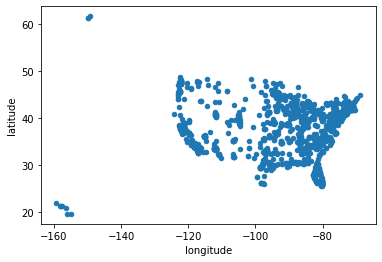

In [ ]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [ ]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [ ]:
import geopandas as gpd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [ ]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [ ]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [ ]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [ ]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

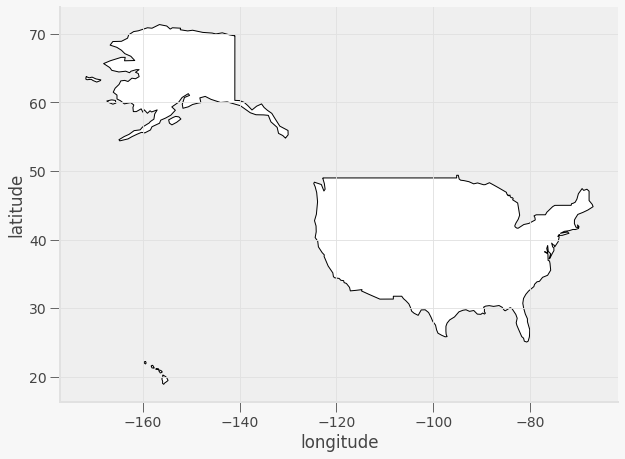

In [ ]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

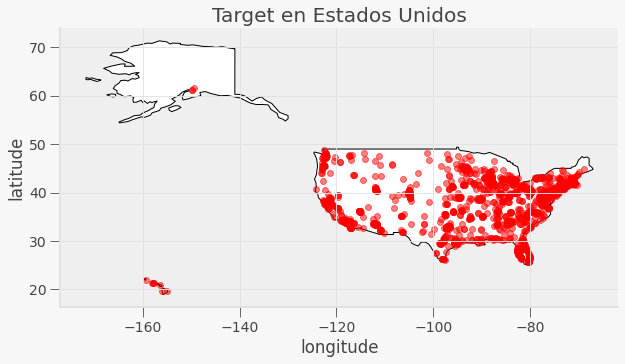

In [ ]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.


###Encuentra el numero ideal de almacenes, justifica tu respuesta:

###1.-Encuentra las latitudes y longitudes de los almacenes, ¿qué ciudad es?, ¿a cuantas tiendas va surtir?, ¿sabes a que distancia estará?
### ¿Cómo elegiste el número de almacenes?, justifica tu respuesta técnicamente.

(Adicionalmente, en el notebook notaras que al inicio exploramos los datos y los graficamos de manera simple, después nos auxiliamos de una librería de datos geográficos.)

###2.- ¿qué librerías nos pueden ayudar a graficar este tipo de datos?
###3.- ¿Consideras importante que se grafique en un mapa?, ¿por qué?
###Agrega las conclusiones


Cargamos la libreria KMeans de Sklearn:

In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns



###Encuentra el numero ideal de almacenes, justifica tu respuesta:

###1.-Encuentra las latitudes y longitudes de los almacenes, ¿qué ciudad es?, ¿a cuantas tiendas va surtir?, ¿sabes a que distancia estará? ¿Cómo elegiste el número de almacenes?, justifica tu respuesta técnicamente.

La Inertia mide que tan bien un conjunto de datos esta siendo clusterizado por K-Means.
Se calcula midiendo las distancias entre cada punto a su centroide y sacando el cuadrado de su distancia y sumando los cuadrados de dichas distancias de todos los puntos en ese cluster.

Un buen modelo es aquel cuya INERTIA es baja y hay un numero bajo de clusters K, sin embargo es una situacion que hay que decidir ya que a medida que K se incrementa (clusters) la inertia decrece.

Para encontrar el punto optimo de K para el dataset, utilizamos el metodo de ELBOW (Metodo de Codo) , para encontrar el punto donde el decremento en la INERTIA empieza a ser muy lento.

Primeramente vamos a entrenar el modelo KMeans para una cantidad diferente de clusters (almacenes) y guardar el valor de Inertia de cada modelo entrenado.
Y dibujamos la curva para encontrar el numero optimo de clusters.


Text(0.5, 1.0, 'Diferentes Valores de Inertia para los Diferentes Numeros de Clusters (Almacenes)')

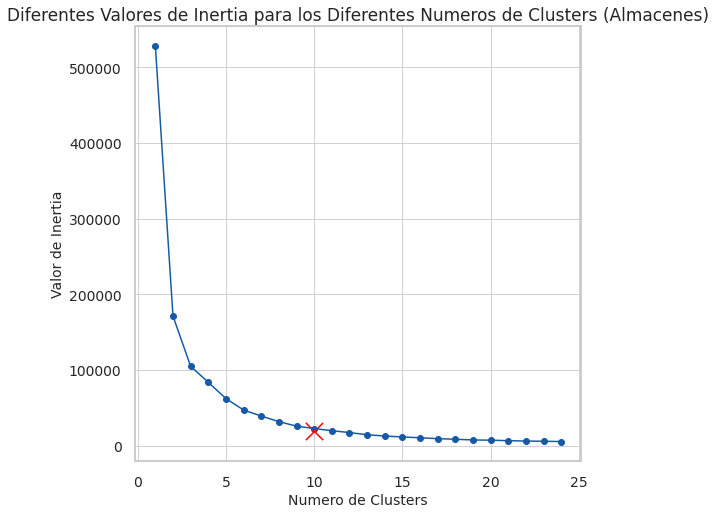

In [ ]:
X = list(zip(gdf.longitude, df.latitude))
MaxWarehouses = 25
# es una cantidad arbitraria que pusimos solo para para graficar

plt.rcParams['figure.figsize'] = [8,8]
sns.set_style("whitegrid")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

inertia_list = []
for num_clusters in range(1, MaxWarehouses):
    kmeans_model = KMeans(n_clusters=num_clusters, init="k-means++")
    kmeans_model.fit(X)
    inertia_list.append(kmeans_model.inertia_)
    
# dibujamos la curva de inertia
plt.plot(range(1,MaxWarehouses),inertia_list)
plt.scatter(range(1,MaxWarehouses),inertia_list)
plt.scatter(10, inertia_list[10], marker="x", s=300, c="r")
plt.xlabel("Numero de Clusters", size=14)
plt.ylabel("Valor de Inertia", size=14)
plt.title("Diferentes Valores de Inertia para los Diferentes Numeros de Clusters (Almacenes)", size=17)


Vemos en la grafica que entre los 10,11,12 Clusters (almacenes) ya la inertia 
empieza a decrecer ya en dichos puntos más despacio.
Vemos que despues de 9 almacenes ya no hay un gran ahorro de distancias (inertia). Y por ejemplo poner 15-20 almacenes o mas seria muy costoso por que la ganancia de inertia es muy poca.


Ahora busquemos los centros de esos K=10 clusters


In [ ]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
centers = kmeans.cluster_centers_

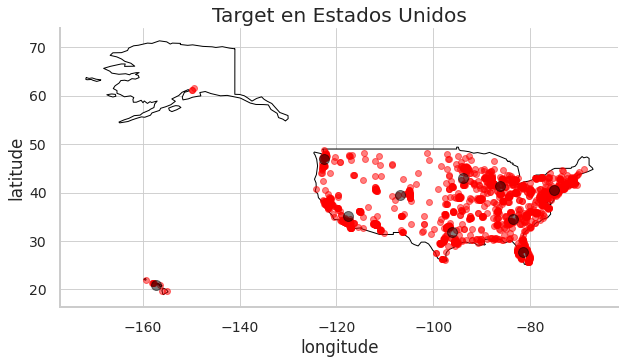

In [ ]:
fig, gax = plt.subplots(figsize=(10,10))

world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

gdf.plot(ax=gax, color='red', alpha = 0.5)
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()


Pero vemos que el estado de Alaska se queda sin almacen. 
Ahora probemos para K=11

In [ ]:
kmeans = KMeans(n_clusters=11)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
centers = kmeans.cluster_centers_

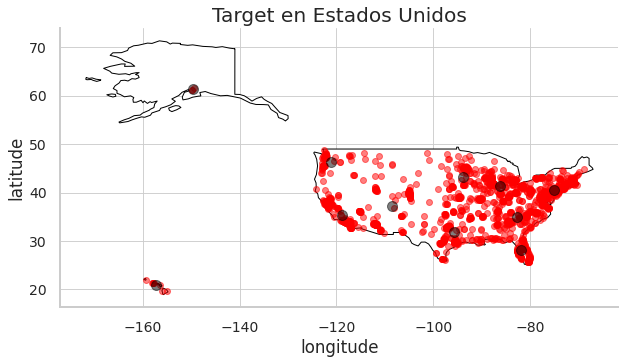

In [ ]:
fig, gax = plt.subplots(figsize=(10,10))

world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

gdf.plot(ax=gax, color='red', alpha = 0.5)
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

Aqui ya cubrimos Alaska. Entonces nos quedamos con K=11.


In [ ]:
labels = kmeans.labels_

10

Ahora veamos la ubicaciones de cada clusters o Almacen:

In [ ]:
centers #ubicaciones de los clusters longitud latitud

array([[-118.92569852,   35.41108603],
       [ -74.99007009,   40.61476804],
       [ -93.89357535,   43.15320229],
       [ -95.80705228,   31.95197604],
       [ -82.6891793 ,   34.96738298],
       [-157.31225085,   20.94542771],
       [-121.15506338,   46.25476682],
       [ -81.94025123,   28.05105292],
       [-108.47333679,   37.21140679],
       [ -86.16633048,   41.32931031],
       [-149.6767927 ,   61.31264473]])

Las ubicaciones son:


In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="myGeocoder")

In [ ]:
label = 1
for clusterx in centers:
  Latitude = clusterx[1]
  Longitude = clusterx[0]
  location = geolocator.reverse(str(Latitude)+','+str(Longitude))
  address = location.raw['address']
  county = address.get('county')
  city = address.get('city')
  state = address.get('state')
  state_district=address.get('state_district')
  suburb= address.get('suburb')
  country = address.get('country')
  zipcode = address.get('postcode')
  print('Center ',label, ' City: ', city, ', County: ', county, ', State: ', state, ', Country:', country, ', Zip Code:', zipcode, ', Coordinates:', Longitude,',',Latitude)
  label = label + 1




Center  1  City:  Bakersfield , County:  Kern County , State:  California , Country: United States , Zip Code: 93306 , Coordinates: -118.92569851788991 , 35.41108603027523
Center  2  City:  None , County:  Hunterdon County , State:  New Jersey , Country: United States , Zip Code: 08827 , Coordinates: -74.99007009407583 , 40.614768035545026
Center  3  City:  None , County:  Hancock County , State:  Iowa , Country: United States , Zip Code: 50423 , Coordinates: -93.89357535364239 , 43.15320229139073
Center  4  City:  None , County:  Anderson County , State:  Texas , Country: United States , Zip Code: None , Coordinates: -95.80705228325581 , 31.951976040930234
Center  5  City:  None , County:  Pickens County , State:  South Carolina , Country: United States , Zip Code: None , Coordinates: -82.68917930110497 , 34.96738298287293
Center  6  City:  None , County:  None , State:  None , Country: United States , Zip Code: None , Coordinates: -157.31225085 , 20.945427712500003
Center  7  City:  

Podemos observar que aunque las ubicaciones no nos indican cuales ciudades al menos con señalan el County (condado) y el estado de cada uno de los 11 centros o almacenes.

###Veamos ahora un diagrama de Voronoi de Decision Boundaries

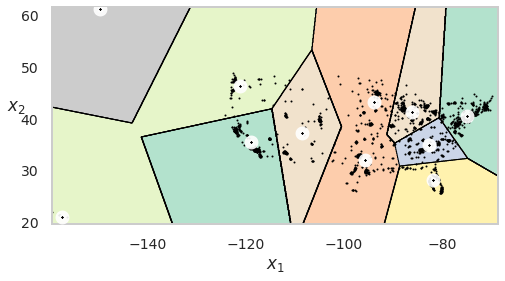

In [ ]:
#Se definen funciones

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

#se grafican las Decision Boundaries con el diagrama de Voronoi
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, np.array(X))
plt.show()

### A cuantas ciudades surtiran? 

In [ ]:
stores_per_center=np.bincount(y_kmeans) #asi se encuentran distribuidas la atencion de cada centro a cuantas tiendas.
stores_per_center

array([218, 422, 151, 215, 180,   8,  74, 132, 129, 307,   3])

Aqui aparecen los almacenes con las respectivas tiendas que atenderan.

Ahora veamos las distancias de cada tiendas a cada almacen y las distancias promedio de las tiendas a su almacen cluster al que pertenecen:

In [ ]:
Distancias=kmeans.transform(np.array(X)).round(2)
Distancias

array([[32.2 , 13.94, 12.2 , ..., 22.03,  8.13, 68.86],
       [32.  , 14.04, 12.  , ..., 21.83,  8.04, 68.65],
       [31.4 , 16.33, 13.91, ..., 21.61, 10.86, 68.99],
       ...,
       [14.68, 31.35, 12.37, ...,  6.05, 20.16, 47.18],
       [15.25, 29.82, 11.09, ...,  5.39, 18.63, 49.19],
       [11.45, 35.91, 16.9 , ...,  6.67, 24.72, 42.79]])

In [ ]:
Distancias.shape#tenemos entonces las distancias de cada tienda a los 11 almacenes

(1839, 11)

In [ ]:
Distancias[0] #distancias de la tienda 0 a los 11 almacenes

array([32.2 , 13.94, 12.2 ,  9.09,  4.47, 71.57, 36.74,  7.1 , 22.03,
        8.13, 68.86])

In [ ]:
Distancias[0].min()#es la distancia minima a la que la tienda 0 tiene al cluster al que pertenece

4.47

In [ ]:
np.argmin(Distancias[0]) # y este es al cluster al que pertenece (almacen)

4

In [ ]:
Distancias[1] #distancias de la tienda 1 a los 11 almacenes

array([32.  , 14.04, 12.  ,  8.93,  4.6 , 71.41, 36.53,  7.31, 21.83,
        8.04, 68.65])

In [ ]:
Distancias[1].min()#es la distancia minima a la que la tienda 1 tiene al cluster al que pertenece

4.6

In [ ]:
np.argmin(Distancias[1]) # y este es al cluster al que pertenece (almacen)

4

Ahora calculemos las distancias minimas promedio de las tiendas por Cluster (Almacen) al que pertenecen:


In [ ]:
average_min_distance=list()

for K_center in stores_per_center:#creamos una lista en ceros para acumular las distancias
  average_min_distance.append(0.0)

for distance in Distancias:# buscaremos las distancias minimas de cada tienda
  min=np.argmin(distance)
  average_min_distance[min]=average_min_distance[min]+distance[min]

for K_center in range(len(average_min_distance)):
  average_min_distance[K_center]=average_min_distance[K_center]/stores_per_center[K_center]
  print ('Distancia Minima Promedio de las tiendas que pertecen al Almacen: ', K_center, ', ',average_min_distance[K_center].round(2))





Distancia Minima Promedio de las tiendas que pertecen al Almacen:  0 ,  2.7
Distancia Minima Promedio de las tiendas que pertecen al Almacen:  1 ,  2.5
Distancia Minima Promedio de las tiendas que pertecen al Almacen:  2 ,  2.89
Distancia Minima Promedio de las tiendas que pertecen al Almacen:  3 ,  3.25
Distancia Minima Promedio de las tiendas que pertecen al Almacen:  4 ,  2.96
Distancia Minima Promedio de las tiendas que pertecen al Almacen:  5 ,  1.3
Distancia Minima Promedio de las tiendas que pertecen al Almacen:  6 ,  2.71
Distancia Minima Promedio de las tiendas que pertecen al Almacen:  7 ,  1.98
Distancia Minima Promedio de las tiendas que pertecen al Almacen:  8 ,  4.83
Distancia Minima Promedio de las tiendas que pertecen al Almacen:  9 ,  2.8
Distancia Minima Promedio de las tiendas que pertecen al Almacen:  10 ,  0.25


###2.- ¿qué librerías nos pueden ayudar a graficar este tipo de datos?

GEOPANDAS
Es la libreria que utilizamos en este ejercicio, nos ayuda a dibujar mapas de manera eficiente.

Aqui el sitio de la libreria:
https://geopandas.org



Veamos este ejemplo:

In [ ]:
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Polygon

In [ ]:
capitals = geopandas.read_file(geopandas.datasets.get_path("naturalearth_cities"))
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

# Create a subset of the world data that is just the South American continent
south_america = world[world["continent"] == "South America"]

# Create a custom polygon
polygon = Polygon([(0, 0), (0, 90), (180, 90), (180, 0), (0, 0)])
poly_gdf = geopandas.GeoDataFrame([1], geometry=[polygon], crs=world.crs)

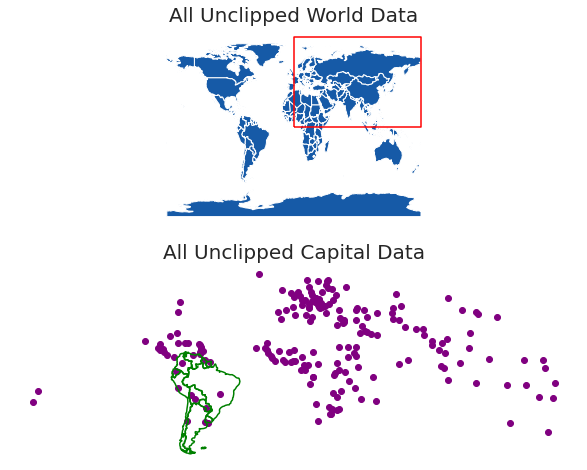

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
world.plot(ax=ax1)
poly_gdf.boundary.plot(ax=ax1, color="red")
south_america.boundary.plot(ax=ax2, color="green")
capitals.plot(ax=ax2, color="purple")
ax1.set_title("All Unclipped World Data", fontsize=20)
ax2.set_title("All Unclipped Capital Data", fontsize=20)
ax1.set_axis_off()
ax2.set_axis_off()
plt.show()

Se vio la diferencia al igual que en el ejercicio cuando los puntos estan relacionados con la forma de los continentes.



GEOPLOT

Es otra libreria de visualizacion da datos geoespaciales diseñada para cientificos y analistas de datos.

Aqui podemos encontrar algunos ejempolos de la Libreria:

https://residentmario.github.io/geoplot/gallery/index.html



En este ejemplo vemos:

un KDEPlot of Boston AirBnB Locations


![imagen.png](https://residentmario.github.io/geoplot/_images/sphx_glr_plot_boston_airbnb_kde_001.png)

###ARCPY

Es parte del paquete de librerias de ArcGIS Python, que incluyen ArcPy and ArcGIS API para Python. 

Utilizando estas librerias, podemos convertir y manejar datos geograficos, automatizar flujos de trabajo espaciales, realizar analiticas espaciales, y contruir modelos de aprendizaje automatico.

Aqui podemos encontrar informacion acerta de esta libreria:

https://www.esri.com/en-us/arcgis/products/arcgis-python-libraries/libraries/arcpy


![imagen.png](https://www.esri.com/content/dam/esrisites/en-us/arcgis/products/arcgis-python-libraries/assets/arcgis-python-arcpy-mts-drive-your-gis-python.png)



###3.- ¿Consideras importante que se grafique en un mapa?, ¿por qué?

Por que nos permite entender de mejor y clara manera las ubicaciones de las coordenadas geograficas de nuestra archivo de datos.
En este ejemplo para entender como se encuentran distribuidas las tiendas Target en todo el pais de Estados Unidos de America y ver donde se tendrian los Clusters o almacenes para las tiendas.


### 4.- Agrega las conclusiones

En este ejercicio entendimos como obtener el numero de almacenes (clusters) utilizando el algoritmo de aprendizaje NO Supervisado: KMEANS.
Utilizamos el metodo ELBOW (codo) para obtener la K que nos diera la menor inercia cuando K ya empezaba a crecer y la inercia no decrecia tanto.

Encontramos que K=10 almacenes , pero vimos que el estado de Alaska , no tenia almacen. En esta disyuntiva, dependerá de hacer un analisis de costo beneficio si conviene tener un almacen en Alaska o no, por los costos de transporte y fletes de enviar mercancia a Alaska desde un almacen cercano fuera de Alaska , o de construir un almacen en Alaska en el condado de Anchorange, como se planteó. Como no teniamos esa información, en este caso decidimos agregar un almacen mas y quedamos con 11 almacenes.
